# Artificial Neural Networks and Deep Learning























---























# Homework 1

## ⚙️ Import Libraries

In [90]:
import numpy as np

import tensorflow as tf

import seaborn as sns

from tensorflow import keras as tfk

from tensorflow.keras import layers as tfkl

import matplotlib.pyplot as plt

import pandas as pd

from sklearn.model_selection import train_test_split

from sklearn.metrics import (

    accuracy_score,

    confusion_matrix,

    precision_score,

    recall_score,

    f1_score,

)

import keras

import cv2



seed = 42

np.random.seed(seed)

tf.random.set_seed(seed)

## ⏳ Load the Data

In [91]:
# Load Data

# data = np.load('aug_edge_data.npz')

data = np.load("/kaggle/input/edge-data/aug_edge_data.npz")

X = data["images"]

y = data["labels"]

np.unique(y, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([2330, 2330, 2330, 2330, 2330, 2330, 2330, 2330]))



## 🔄 Process Data


In [92]:
X[0].max()

255

In [93]:
# Convert labels to categorical format using one-hot encoding

y = tfk.utils.to_categorical(y)



test_val_size = 0.05 # parameter to tune



# Split data into train_val and test sets

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, random_state=seed, test_size=test_val_size, stratify=np.argmax(y,axis=1))



# Further split train_val into train and validation sets

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=len(X_test), stratify=np.argmax(y_train_val,axis=1))



# Print shapes of the datasets

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (16776, 96, 96, 3), y_train shape: (16776, 8)
X_val shape: (932, 96, 96, 3), y_val shape: (932, 8)
X_test shape: (932, 96, 96, 3), y_test shape: (932, 8)


## 🧮 Define Network Parameters


In [94]:
# Input shape for the model

input_shape = X_train.shape[1:]



# Output shape for the model

output_shape = y_train.shape[1]



print("Input Shape:", input_shape)

print("Output Shape:", output_shape)

Input Shape: (96, 96, 3)
Output Shape: 8


In [95]:
#Number of training epochs

epochs = 10 # parameter to tune



# Batch size for training

batch_size = 64 # parameter to tune



# Learning rate: step size for updating the model's weights

learning_rate = 0.001 # parameter to tune



# Print the defined parameters

print("Epochs:", epochs)

print("Batch Size:", batch_size)

print("Learning Rate:", learning_rate)

Epochs: 10
Batch Size: 64
Learning Rate: 0.001


## 🛠️ Build the Model

In [96]:
model_large = keras.applications.ConvNeXtXLarge(

    include_top=False, #can change this

    include_preprocessing=True,

    weights="imagenet",

    input_tensor=None,

    input_shape=input_shape,

    pooling="avg", #can change this

    classes=8,

    classifier_activation="softmax"    

)

# tfk.utils.plot_model(model_large, show_shapes=True)

### Custom functions to recieve input

In [97]:
def edge_highlighting(image):
    # image = (image * 255).astype(np.uint8)
    image = tf.cast(image * 255, tf.uint8).numpy()
    
    THRESH_VALUE_STRICT = 120
    THRESH_BINARY = cv2.THRESH_BINARY    
    THRESH_MAX_VALUE = 255

    # Transition into shades of gray
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Create strict mask
    _, mask = cv2.threshold(
        gray_img, THRESH_VALUE_STRICT, THRESH_MAX_VALUE, THRESH_BINARY
    )
    
    # Generate intersection between strict mask and original image
    siloutte = image.copy()
    siloutte[mask == 255] = 255 # overlapping the strict mask with the white pixels

    # Sobel operator implementation for axises X and Y
    sobelx = cv2.Sobel(siloutte, cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(siloutte, cv2.CV_64F, 0, 1, ksize=5)

    # Gradient calculation
    gradient_magnitude = np.sqrt(sobelx**2 + sobely**2)

    # Gradient normalization
    gradient_magnitude = np.uint8(gradient_magnitude / gradient_magnitude.max() * 255)

    # Invert colors for better visualization 
    gradient_orig = cv2.bitwise_not(gradient_magnitude)

    return gradient_orig

In [98]:
@keras.saving.register_keras_serializable()
class EdgeHighlightingLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EdgeHighlightingLayer, self).__init__(**kwargs)

    def call(self, inputs):
        output = tf.map_fn(lambda x: tf.py_function(edge_highlighting, [x], tf.float32), inputs)
        output.set_shape([None, 96, 96, 3])
        return output


    def compute_output_shape(self, input_shape):
        return input_shape
        

In [99]:
X[0].shape

(96, 96, 3)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Augmentation (Sequential)       │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_flip_12             │ (None, 96, 96, 3)      │             0 │
│ (RandomFlip)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_translation_12      │ (None, 96, 96, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_rotation_12         │ (None, 96, 96, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ random_zoom_12             │ (None, 96, 96, 3)      │             0 │
│ (RandomZoom)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ edge_highlighting_layer_12      │ (None, 96, 96, 3)      │             0 │
│ (EdgeHighlightingLayer)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_xlarge (Functional)    │ (None, 2048)           │   348,147,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ input_layer_22             │ (None, 96, 96, 3)      │             0 │
│ (InputLayer)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 96, 96, 3)      │             0 │
│ convnext_xlarge_prestem_normal… │                        │               │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └ convnext_xlarge_stem       │ (None, 24, 24, 256)    │        13,056 │
│ (Sequential)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └                         │ (None, 24, 24, 256)    │        12,544 │
│ convnext_xlarge_stem_conv       │                        │               │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│       └                         │ (None, 24, 24, 256)    │           512 │
│ convnext_xlarge_stem_layernorm  │                        │               │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 256)    │        12,800 │
│ convnext_xlarge_stage_0_block_… │                        │               │
│ (Conv2D)                        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 256)    │           512 │
│ convnext_xlarge_stage_0_block_… │                        │               │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│    └                            │ (None, 24, 24, 1024)   │       263,168 │
│ convnext_xlarge_stage_0_block_… │                        │             

 Total params: 349,374,088 (1.30 GB)

 Trainable params: 1,220,232 (4.65 MB)

 Non-trainable params: 348,153,856 (1.30 GB)

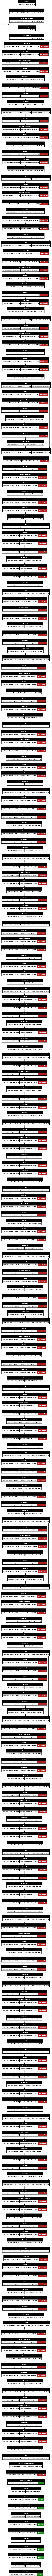

In [100]:
model_large.trainable = False #Freeze the weights of the CNN

tf.random.set_seed(seed)



# Create an input layer with shape (96, 96, 3)

inputs = tfk.Input(shape=(96, 96, 3), name='input_layer')



augmentation = tf.keras.Sequential([

    tfkl.RandomFlip("horizontal_and_vertical"),

    tfkl.RandomTranslation(0.2,0.2),

    tfkl.RandomRotation(0.2),

    tfkl.RandomZoom(0.2),

], name='Augmentation')



x = augmentation(inputs)



# Preprocess the input with the function used to preprocess the data to train the model

x = EdgeHighlightingLayer()(x)



# Connect ConvNeXtXLarge to the input

x = model_large(x)



###################################################################################################

# Adding additional layers here

x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.5)(x)



x = tfkl.Dense(512, activation='relu', name='dense1')(x)

x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.5)(x)



x = tfkl.Dense(256, activation='relu', name='dense2')(x)

x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.5)(x)



x = tfkl.Dense(128, activation='relu', name='dense3')(x)

x = tfkl.BatchNormalization()(x)

x = tfkl.Dropout(0.5)(x)

###################################################################################################

# Add a Dense layer with 8 units and softmax activation as the classifier

outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)



# Create a Model connecting input and output

model = tfk.Model(inputs=inputs, outputs=outputs, name='model')



# Compile the model with Categorical Cross-Entropy loss and Adam optimizer

model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.AdamW(learning_rate), metrics=['accuracy'])



# Display a summary of the model architecture

model.summary(expand_nested=True)



# Display model architecture with layer shapes and trainable parameters

tfk.utils.plot_model(model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

## 🛠️ Train and Save the Model

In [101]:
# Define the patience value for early stopping

patience = 10 # parameter to tune



# Create an EarlyStopping callback

early_stopping = tfk.callbacks.EarlyStopping(

    monitor='val_accuracy',

    mode='max',

    patience=patience,

    restore_best_weights=True

)



reduce_lr = tfk.callbacks.ReduceLROnPlateau(

    monitor="val_loss", factor=0.5, patience=patience, min_lr=1e-6, verbose=1

)

# Store the callback in a list

callbacks = [early_stopping, reduce_lr]

In [102]:
X_train.shape,y_train.shape

((16776, 96, 96, 3), (16776, 8))

In [103]:
# Train the model with early stopping callback

history = model.fit(

    x=X_train*255, #The model takes inputs in the range 0-255 

    y=y_train,

    batch_size=batch_size,

    epochs=epochs,

    validation_data=(X_val*255, y_val),

    callbacks=callbacks

).history



# Calculate and print the final validation accuracy

final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)

print(f'Final validation accuracy: {final_val_accuracy}%')



# Save the trained model to a file with the accuracy included in the filename

model_filename = 'model_large.keras'

model.save(model_filename)



# Delete the model to free up resources

del model

Epoch 1/10
100/263 ━━━━━━━━━━━━━━━━━━━━ 4:22 2s/step - accuracy: 0.2590 - loss: 2.5856

/tmp/ipykernel_337/1444358538.py:29: RuntimeWarning: invalid value encountered in divide
  gradient_magnitude = np.uint8(gradient_magnitude / gradient_magnitude.max() * 255)
/tmp/ipykernel_337/1444358538.py:29: RuntimeWarning: invalid value encountered in cast
  gradient_magnitude = np.uint8(gradient_magnitude / gradient_magnitude.max() * 255)


263/263 ━━━━━━━━━━━━━━━━━━━━ 474s 2s/step - accuracy: 0.3059 - loss: 2.2483 - val_accuracy: 0.2597 - val_loss: 3.5319 - learning_rate: 0.0010
Epoch 2/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.4169 - loss: 1.5073 - val_accuracy: 0.2597 - val_loss: 3.3559 - learning_rate: 0.0010
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - accuracy: 0.4564 - loss: 1.3952 - val_accuracy: 0.2876 - val_loss: 3.3057 - learning_rate: 0.0010
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - accuracy: 0.4693 - loss: 1.3493 - val_accuracy: 0.2983 - val_loss: 3.0307 - learning_rate: 0.0010
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - accuracy: 0.4879 - loss: 1.3290 - val_accuracy: 0.2639 - val_loss: 3.3833 - learning_rate: 0.0010
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.5050 - loss: 1.2940 - val_accuracy: 0.2768 - val_loss: 3.1249 - learning_rate: 0.0010
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 447s 2s/step - accuracy: 0.5013 - loss: 1.2925 - val_

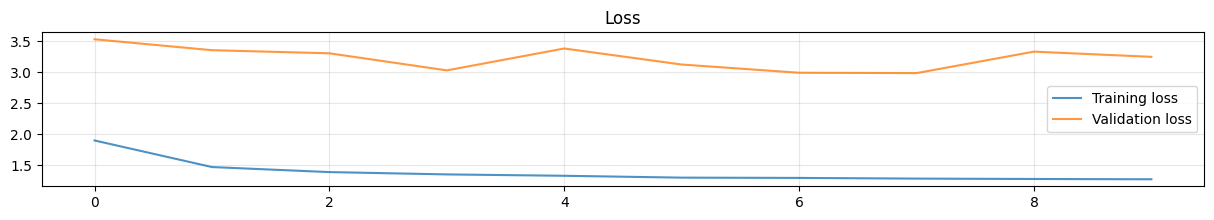

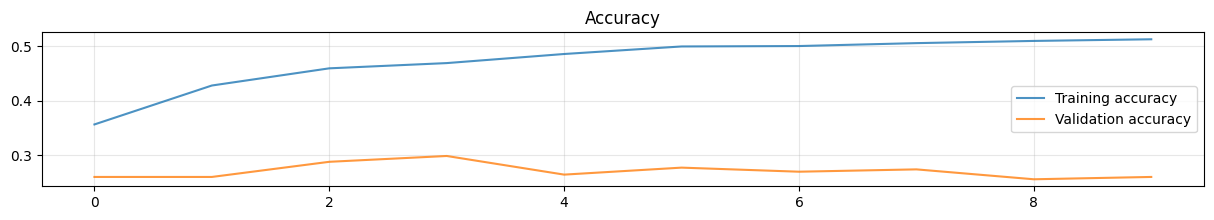

In [104]:
# Plot training and validation loss



plt.figure(figsize=(15, 2))

plt.plot(history["loss"], label="Training loss", alpha=0.8)

plt.plot(history["val_loss"], label="Validation loss", alpha=0.8)

plt.title("Loss")

plt.legend()

plt.grid(alpha=0.3)



# Plot training and validation accuracy

plt.figure(figsize=(15, 2))

plt.plot(history["accuracy"], label="Training accuracy", alpha=0.8)

plt.plot(history["val_accuracy"], label="Validation accuracy", alpha=0.8)

plt.title("Accuracy")

plt.legend()

plt.grid(alpha=0.3)

plt.show()

## 🕹️ Use the Model - Make Inference

In [105]:
# Load the saved model

# model = tfk.models.load_model('cell.keras')



model = tfk.models.load_model('/kaggle/working/model_large.keras')



# Display a summary of the model architecture

model.summary(expand_nested=True, show_trainable=True)

TypeError: <class 'keras.src.models.functional.Functional'> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

config={'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'model', 'trainable': True, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 96, 96, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None, 'name': 'input_layer', 'inbound_nodes': []}, {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'Augmentation', 'trainable': True, 'dtype': 'float32', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 96, 96, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_27'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'RandomFlip', 'config': {'name': 'random_flip_12', 'trainable': True, 'dtype': 'float32', 'seed': None, 'mode': 'horizontal_and_vertical'}, 'registered_name': None, 'build_config': {'input_shape': [None, 96, 96, 3]}}, {'module': 'keras.layers', 'class_name': 'RandomTranslation', 'config': {'name': 'random_translation_12', 'trainable': True, 'dtype': 'float32', 'height_factor': 0.2, 'width_factor': 0.2, 'fill_mode': 'reflect', 'interpolation': 'bilinear', 'seed': None, 'fill_value': 0.0, 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 96, 96, 3]}}, {'module': 'keras.layers', 'class_name': 'RandomRotation', 'config': {'name': 'random_rotation_12', 'trainable': True, 'dtype': 'float32', 'factor': [-0.2, 0.2], 'value_range': [0, 255], 'data_format': 'channels_last', 'fill_mode': 'reflect', 'fill_value': 0.0, 'interpolation': 'bilinear', 'seed': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 96, 96, 3]}}, {'module': 'keras.layers', 'class_name': 'RandomZoom', 'config': {'name': 'random_zoom_12', 'trainable': True, 'dtype': 'float32', 'height_factor': 0.2, 'width_factor': None, 'fill_mode': 'reflect', 'interpolation': 'bilinear', 'seed': None, 'fill_value': 0.0, 'data_format': 'channels_last'}, 'registered_name': None, 'build_config': {'input_shape': [None, 96, 96, 3]}}], 'build_input_shape': [None, 96, 96, 3]}, 'registered_name': None, 'build_config': {'input_shape': [None, 96, 96, 3]}, 'name': 'Augmentation', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 96, 96, 3], 'dtype': 'float32', 'keras_history': ['input_layer', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': None, 'class_name': 'EdgeHighlightingLayer', 'config': {'name': 'edge_highlighting_layer_12', 'trainable': True, 'dtype': 'float32'}, 'registered_name': 'EdgeHighlightingLayer', 'build_config': {'input_shape': [None, 96, 96, 3]}, 'name': 'edge_highlighting_layer_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 96, 96, 3], 'dtype': 'float32', 'keras_history': ['Augmentation', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.models.functional', 'class_name': 'Functional', 'config': {'name': 'convnext_xlarge', 'trainable': False, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 96, 96, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_22'}, 'registered_name': None, 'name': 'input_layer_22', 'inbound_nodes': []}, {'module': 'keras.layers', 'class_name': 'Normalization', 'config': {'name': 'convnext_xlarge_prestem_normalization', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'invert': False, 'mean': [123.675, 116.28, 103.53], 'variance': [3409.9760250000004, 3262.6944000000003, 3291.890625]}, 'registered_name': None, 'build_config': {'input_shape': [None, 96, 96, 3]}, 'name': 'convnext_xlarge_prestem_normalization', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 96, 96, 3], 'dtype': 'float32', 'keras_history': ['input_layer_22', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'convnext_xlarge_stem', 'trainable': False, 'dtype': 'float32', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 96, 96, 3], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_23'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stem_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [4, 4], 'strides': [4, 4], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 96, 96, 3]}}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stem_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 256]}}], 'build_input_shape': [None, 96, 96, 3]}, 'registered_name': None, 'build_config': {'input_shape': [None, 96, 96, 3]}, 'name': 'convnext_xlarge_stem', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 96, 96, 3], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_prestem_normalization', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_0_block_0_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 256, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 256]}, 'name': 'convnext_xlarge_stage_0_block_0_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stem', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_0_block_0_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 256]}, 'name': 'convnext_xlarge_stage_0_block_0_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_0_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_0_block_0_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 256]}, 'name': 'convnext_xlarge_stage_0_block_0_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_0_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_0_block_0_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 1024]}, 'name': 'convnext_xlarge_stage_0_block_0_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_0_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_0_block_0_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 256, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 1024]}, 'name': 'convnext_xlarge_stage_0_block_0_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_0_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_0_block_0_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 256}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 24, 24, 256]}, 'name': 'convnext_xlarge_stage_0_block_0_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_0_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_0_block_0_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 256]}, 'name': 'convnext_xlarge_stage_0_block_0_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_0_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_72'}, 'registered_name': 'Add', 'name': 'add_72', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stem', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_0_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_0_block_1_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 256, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 256]}, 'name': 'convnext_xlarge_stage_0_block_1_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['add_72', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_0_block_1_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 256]}, 'name': 'convnext_xlarge_stage_0_block_1_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_1_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_0_block_1_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 256]}, 'name': 'convnext_xlarge_stage_0_block_1_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_1_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_0_block_1_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 1024]}, 'name': 'convnext_xlarge_stage_0_block_1_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_1_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_0_block_1_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 256, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 1024]}, 'name': 'convnext_xlarge_stage_0_block_1_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_1_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_0_block_1_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 256}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 24, 24, 256]}, 'name': 'convnext_xlarge_stage_0_block_1_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_1_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_0_block_1_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 256]}, 'name': 'convnext_xlarge_stage_0_block_1_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_1_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_73'}, 'registered_name': 'Add', 'name': 'add_73', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['add_72', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_1_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_0_block_2_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 256, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 256, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 256]}, 'name': 'convnext_xlarge_stage_0_block_2_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['add_73', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_0_block_2_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 256]}, 'name': 'convnext_xlarge_stage_0_block_2_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_2_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_0_block_2_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 256]}, 'name': 'convnext_xlarge_stage_0_block_2_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_2_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_0_block_2_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 1024]}, 'name': 'convnext_xlarge_stage_0_block_2_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_2_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_0_block_2_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 256, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 1024]}, 'name': 'convnext_xlarge_stage_0_block_2_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_2_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_0_block_2_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 256}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 24, 24, 256]}, 'name': 'convnext_xlarge_stage_0_block_2_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_2_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_0_block_2_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 256]}, 'name': 'convnext_xlarge_stage_0_block_2_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_2_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_74'}, 'registered_name': 'Add', 'name': 'add_74', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['add_73', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_0_block_2_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'convnext_xlarge_downsampling_block_0', 'trainable': False, 'dtype': 'float32', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 24, 24, 256], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_24'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_downsampling_layernorm_0', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 256]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_downsampling_conv_0', 'trainable': False, 'dtype': 'float32', 'filters': 512, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 256]}}], 'build_input_shape': [None, 24, 24, 256]}, 'registered_name': None, 'build_config': {'input_shape': [None, 24, 24, 256]}, 'name': 'convnext_xlarge_downsampling_block_0', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 24, 24, 256], 'dtype': 'float32', 'keras_history': ['add_74', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_1_block_0_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 512, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 512, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 512]}, 'name': 'convnext_xlarge_stage_1_block_0_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_downsampling_block_0', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_1_block_0_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 512]}, 'name': 'convnext_xlarge_stage_1_block_0_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_0_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_1_block_0_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 2048, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 512]}, 'name': 'convnext_xlarge_stage_1_block_0_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_0_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_1_block_0_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 2048]}, 'name': 'convnext_xlarge_stage_1_block_0_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_0_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_1_block_0_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 512, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 2048]}, 'name': 'convnext_xlarge_stage_1_block_0_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_0_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_1_block_0_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 512}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 12, 12, 512]}, 'name': 'convnext_xlarge_stage_1_block_0_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_0_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_1_block_0_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 512]}, 'name': 'convnext_xlarge_stage_1_block_0_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_0_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_75'}, 'registered_name': 'Add', 'name': 'add_75', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_downsampling_block_0', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_0_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_1_block_1_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 512, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 512, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 512]}, 'name': 'convnext_xlarge_stage_1_block_1_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['add_75', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_1_block_1_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 512]}, 'name': 'convnext_xlarge_stage_1_block_1_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_1_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_1_block_1_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 2048, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 512]}, 'name': 'convnext_xlarge_stage_1_block_1_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_1_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_1_block_1_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 2048]}, 'name': 'convnext_xlarge_stage_1_block_1_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_1_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_1_block_1_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 512, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 2048]}, 'name': 'convnext_xlarge_stage_1_block_1_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_1_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_1_block_1_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 512}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 12, 12, 512]}, 'name': 'convnext_xlarge_stage_1_block_1_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_1_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_1_block_1_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 512]}, 'name': 'convnext_xlarge_stage_1_block_1_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_1_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_76'}, 'registered_name': 'Add', 'name': 'add_76', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['add_75', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_1_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_1_block_2_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 512, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 512, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 512]}, 'name': 'convnext_xlarge_stage_1_block_2_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['add_76', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_1_block_2_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 512]}, 'name': 'convnext_xlarge_stage_1_block_2_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_2_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_1_block_2_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 2048, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 512]}, 'name': 'convnext_xlarge_stage_1_block_2_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_2_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_1_block_2_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 2048]}, 'name': 'convnext_xlarge_stage_1_block_2_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_2_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_1_block_2_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 512, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 2048]}, 'name': 'convnext_xlarge_stage_1_block_2_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_2_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_1_block_2_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 512}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 12, 12, 512]}, 'name': 'convnext_xlarge_stage_1_block_2_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_2_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_1_block_2_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 512]}, 'name': 'convnext_xlarge_stage_1_block_2_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_2_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_77'}, 'registered_name': 'Add', 'name': 'add_77', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['add_76', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_1_block_2_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'convnext_xlarge_downsampling_block_1', 'trainable': False, 'dtype': 'float32', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 12, 12, 512], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_25'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_downsampling_layernorm_1', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 512]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_downsampling_conv_1', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 512]}}], 'build_input_shape': [None, 12, 12, 512]}, 'registered_name': None, 'build_config': {'input_shape': [None, 12, 12, 512]}, 'name': 'convnext_xlarge_downsampling_block_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 12, 12, 512], 'dtype': 'float32', 'keras_history': ['add_77', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_0_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_0_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_downsampling_block_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_0_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_0_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_0_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_0_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_0_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_0_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_0_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_0_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_0_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_0_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_0_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_0_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_0_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_0_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_0_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_0_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_0_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_0_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_78'}, 'registered_name': 'Add', 'name': 'add_78', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_downsampling_block_1', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_0_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_1_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_1_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_78', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_1_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_1_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_1_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_1_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_1_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_1_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_1_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_1_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_1_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_1_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_1_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_1_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_1_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_1_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_1_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_1_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_1_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_1_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_79'}, 'registered_name': 'Add', 'name': 'add_79', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_78', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_1_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_2_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_2_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_79', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_2_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_2_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_2_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_2_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_2_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_2_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_2_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_2_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_2_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_2_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_2_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_2_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_2_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_2_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_2_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_2_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_2_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_2_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_80'}, 'registered_name': 'Add', 'name': 'add_80', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_79', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_2_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_3_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_3_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_80', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_3_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_3_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_3_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_3_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_3_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_3_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_3_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_3_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_3_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_3_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_3_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_3_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_3_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_3_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_3_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_3_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_3_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_3_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_81'}, 'registered_name': 'Add', 'name': 'add_81', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_80', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_3_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_4_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_4_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_81', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_4_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_4_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_4_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_4_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_4_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_4_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_4_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_4_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_4_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_4_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_4_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_4_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_4_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_4_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_4_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_4_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_4_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_4_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_82'}, 'registered_name': 'Add', 'name': 'add_82', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_81', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_4_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_5_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_5_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_82', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_5_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_5_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_5_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_5_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_5_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_5_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_5_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_5_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_5_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_5_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_5_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_5_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_5_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_5_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_5_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_5_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_5_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_5_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_83'}, 'registered_name': 'Add', 'name': 'add_83', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_82', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_5_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_6_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_6_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_83', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_6_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_6_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_6_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_6_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_6_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_6_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_6_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_6_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_6_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_6_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_6_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_6_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_6_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_6_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_6_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_6_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_6_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_6_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_84'}, 'registered_name': 'Add', 'name': 'add_84', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_83', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_6_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_7_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_7_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_84', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_7_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_7_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_7_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_7_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_7_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_7_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_7_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_7_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_7_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_7_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_7_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_7_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_7_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_7_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_7_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_7_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_7_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_7_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_85'}, 'registered_name': 'Add', 'name': 'add_85', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_84', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_7_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_8_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_8_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_85', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_8_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_8_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_8_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_8_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_8_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_8_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_8_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_8_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_8_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_8_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_8_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_8_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_8_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_8_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_8_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_8_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_8_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_8_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_86'}, 'registered_name': 'Add', 'name': 'add_86', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_85', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_8_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_9_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_9_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_86', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_9_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_9_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_9_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_9_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_9_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_9_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_9_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_9_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_9_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_9_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_9_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_9_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_9_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_9_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_9_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_9_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_9_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_9_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_87'}, 'registered_name': 'Add', 'name': 'add_87', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_86', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_9_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_10_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_10_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_87', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_10_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_10_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_10_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_10_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_10_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_10_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_10_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_10_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_10_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_10_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_10_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_10_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_10_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_10_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_10_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_10_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_10_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_10_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_88'}, 'registered_name': 'Add', 'name': 'add_88', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_87', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_10_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_11_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_11_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_88', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_11_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_11_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_11_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_11_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_11_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_11_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_11_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_11_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_11_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_11_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_11_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_11_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_11_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_11_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_11_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_11_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_11_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_11_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_89'}, 'registered_name': 'Add', 'name': 'add_89', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_88', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_11_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_12_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_12_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_89', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_12_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_12_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_12_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_12_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_12_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_12_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_12_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_12_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_12_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_12_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_12_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_12_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_12_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_12_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_12_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_12_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_12_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_12_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_90'}, 'registered_name': 'Add', 'name': 'add_90', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_89', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_12_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_13_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_13_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_90', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_13_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_13_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_13_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_13_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_13_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_13_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_13_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_13_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_13_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_13_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_13_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_13_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_13_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_13_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_13_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_13_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_13_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_13_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_91'}, 'registered_name': 'Add', 'name': 'add_91', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_90', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_13_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_14_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_14_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_91', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_14_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_14_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_14_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_14_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_14_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_14_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_14_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_14_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_14_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_14_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_14_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_14_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_14_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_14_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_14_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_14_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_14_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_14_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_92'}, 'registered_name': 'Add', 'name': 'add_92', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_91', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_14_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_15_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_15_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_92', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_15_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_15_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_15_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_15_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_15_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_15_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_15_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_15_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_15_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_15_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_15_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_15_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_15_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_15_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_15_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_15_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_15_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_15_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_93'}, 'registered_name': 'Add', 'name': 'add_93', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_92', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_15_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_16_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_16_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_93', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_16_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_16_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_16_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_16_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_16_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_16_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_16_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_16_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_16_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_16_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_16_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_16_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_16_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_16_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_16_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_16_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_16_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_16_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_94'}, 'registered_name': 'Add', 'name': 'add_94', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_93', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_16_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_17_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_17_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_94', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_17_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_17_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_17_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_17_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_17_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_17_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_17_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_17_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_17_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_17_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_17_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_17_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_17_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_17_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_17_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_17_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_17_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_17_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_95'}, 'registered_name': 'Add', 'name': 'add_95', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_94', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_17_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_18_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_18_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_95', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_18_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_18_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_18_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_18_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_18_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_18_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_18_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_18_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_18_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_18_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_18_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_18_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_18_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_18_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_18_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_18_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_18_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_18_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_96'}, 'registered_name': 'Add', 'name': 'add_96', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_95', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_18_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_19_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_19_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_96', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_19_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_19_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_19_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_19_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_19_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_19_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_19_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_19_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_19_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_19_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_19_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_19_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_19_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_19_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_19_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_19_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_19_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_19_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_97'}, 'registered_name': 'Add', 'name': 'add_97', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_96', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_19_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_20_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_20_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_97', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_20_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_20_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_20_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_20_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_20_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_20_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_20_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_20_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_20_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_20_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_20_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_20_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_20_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_20_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_20_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_20_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_20_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_20_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_98'}, 'registered_name': 'Add', 'name': 'add_98', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_97', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_20_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_21_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_21_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_98', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_21_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_21_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_21_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_21_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_21_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_21_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_21_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_21_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_21_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_21_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_21_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_21_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_21_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_21_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_21_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_21_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_21_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_21_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_99'}, 'registered_name': 'Add', 'name': 'add_99', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_98', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_21_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_22_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_22_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_99', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_22_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_22_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_22_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_22_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_22_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_22_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_22_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_22_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_22_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_22_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_22_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_22_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_22_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_22_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_22_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_22_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_22_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_22_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_100'}, 'registered_name': 'Add', 'name': 'add_100', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_99', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_22_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_23_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_23_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_100', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_23_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_23_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_23_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_23_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_23_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_23_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_23_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_23_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_23_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_23_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_23_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_23_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_23_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_23_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_23_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_23_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_23_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_23_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_101'}, 'registered_name': 'Add', 'name': 'add_101', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_100', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_23_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_24_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_24_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_101', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_24_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_24_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_24_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_24_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_24_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_24_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_24_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_24_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_24_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_24_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_24_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_24_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_24_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_24_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_24_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_24_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_24_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_24_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_102'}, 'registered_name': 'Add', 'name': 'add_102', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_101', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_24_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_25_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_25_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_102', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_25_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_25_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_25_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_25_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_25_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_25_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_25_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_25_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_25_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_25_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_25_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_25_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_25_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_25_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_25_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_25_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_25_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_25_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_103'}, 'registered_name': 'Add', 'name': 'add_103', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_102', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_25_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_2_block_26_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 1024, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_26_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_103', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_2_block_26_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_26_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_26_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_26_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 4096, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_26_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_26_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_26_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_26_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_26_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_2_block_26_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 1024, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 4096]}, 'name': 'convnext_xlarge_stage_2_block_26_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 4096], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_26_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_2_block_26_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 1024}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_26_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_26_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_2_block_26_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_stage_2_block_26_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_26_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_104'}, 'registered_name': 'Add', 'name': 'add_104', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_103', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_2_block_26_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras', 'class_name': 'Sequential', 'config': {'name': 'convnext_xlarge_downsampling_block_2', 'trainable': False, 'dtype': 'float32', 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': [None, 6, 6, 1024], 'dtype': 'float32', 'sparse': False, 'name': 'input_layer_26'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_downsampling_layernorm_2', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_downsampling_conv_2', 'trainable': False, 'dtype': 'float32', 'filters': 2048, 'kernel_size': [2, 2], 'strides': [2, 2], 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 1, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}}], 'build_input_shape': [None, 6, 6, 1024]}, 'registered_name': None, 'build_config': {'input_shape': [None, 6, 6, 1024]}, 'name': 'convnext_xlarge_downsampling_block_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 6, 6, 1024], 'dtype': 'float32', 'keras_history': ['add_104', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_3_block_0_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 2048, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 2048, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 2048]}, 'name': 'convnext_xlarge_stage_3_block_0_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_downsampling_block_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_3_block_0_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 2048]}, 'name': 'convnext_xlarge_stage_3_block_0_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_0_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_3_block_0_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 8192, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 2048]}, 'name': 'convnext_xlarge_stage_3_block_0_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_0_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_3_block_0_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 8192]}, 'name': 'convnext_xlarge_stage_3_block_0_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 8192], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_0_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_3_block_0_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 2048, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 8192]}, 'name': 'convnext_xlarge_stage_3_block_0_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 8192], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_0_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_3_block_0_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 2048}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 3, 3, 2048]}, 'name': 'convnext_xlarge_stage_3_block_0_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_0_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_3_block_0_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 2048]}, 'name': 'convnext_xlarge_stage_3_block_0_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_0_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_105'}, 'registered_name': 'Add', 'name': 'add_105', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_downsampling_block_2', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_0_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_3_block_1_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 2048, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 2048, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 2048]}, 'name': 'convnext_xlarge_stage_3_block_1_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['add_105', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_3_block_1_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 2048]}, 'name': 'convnext_xlarge_stage_3_block_1_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_1_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_3_block_1_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 8192, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 2048]}, 'name': 'convnext_xlarge_stage_3_block_1_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_1_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_3_block_1_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 8192]}, 'name': 'convnext_xlarge_stage_3_block_1_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 8192], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_1_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_3_block_1_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 2048, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 8192]}, 'name': 'convnext_xlarge_stage_3_block_1_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 8192], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_1_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_3_block_1_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 2048}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 3, 3, 2048]}, 'name': 'convnext_xlarge_stage_3_block_1_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_1_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_3_block_1_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 2048]}, 'name': 'convnext_xlarge_stage_3_block_1_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_1_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_106'}, 'registered_name': 'Add', 'name': 'add_106', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['add_105', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_1_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Conv2D', 'config': {'name': 'convnext_xlarge_stage_3_block_2_depthwise_conv', 'trainable': False, 'dtype': 'float32', 'filters': 2048, 'kernel_size': [7, 7], 'strides': [1, 1], 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': [1, 1], 'groups': 2048, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 2048]}, 'name': 'convnext_xlarge_stage_3_block_2_depthwise_conv', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['add_106', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'convnext_xlarge_stage_3_block_2_layernorm', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 2048]}, 'name': 'convnext_xlarge_stage_3_block_2_layernorm', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_2_depthwise_conv', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_3_block_2_pointwise_conv_1', 'trainable': False, 'dtype': 'float32', 'units': 8192, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 2048]}, 'name': 'convnext_xlarge_stage_3_block_2_pointwise_conv_1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_2_layernorm', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_3_block_2_gelu', 'trainable': False, 'dtype': 'float32', 'activation': 'gelu'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 8192]}, 'name': 'convnext_xlarge_stage_3_block_2_gelu', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 8192], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_2_pointwise_conv_1', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'convnext_xlarge_stage_3_block_2_pointwise_conv_2', 'trainable': False, 'dtype': 'float32', 'units': 2048, 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 8192]}, 'name': 'convnext_xlarge_stage_3_block_2_pointwise_conv_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 8192], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_2_gelu', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.applications.convnext', 'class_name': 'LayerScale', 'config': {'name': 'convnext_xlarge_stage_3_block_2_layer_scale', 'trainable': False, 'dtype': 'float32', 'init_values': 1e-06, 'projection_dim': 2048}, 'registered_name': 'LayerScale', 'build_config': {'input_shape': [None, 3, 3, 2048]}, 'name': 'convnext_xlarge_stage_3_block_2_layer_scale', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_2_pointwise_conv_2', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'Activation', 'config': {'name': 'convnext_xlarge_stage_3_block_2_identity', 'trainable': False, 'dtype': 'float32', 'activation': 'linear'}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 2048]}, 'name': 'convnext_xlarge_stage_3_block_2_identity', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_2_layer_scale', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.src.ops.numpy', 'class_name': 'Add', 'config': {'name': 'add_107'}, 'registered_name': 'Add', 'name': 'add_107', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['add_106', 0, 0]}}, {'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge_stage_3_block_2_identity', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'GlobalAveragePooling2D', 'config': {'name': 'global_average_pooling2d_2', 'trainable': False, 'dtype': 'float32', 'data_format': 'channels_last', 'keepdims': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 3, 3, 2048]}, 'name': 'global_average_pooling2d_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 3, 3, 2048], 'dtype': 'float32', 'keras_history': ['add_107', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'LayerNormalization', 'config': {'name': 'layer_normalization_2', 'trainable': False, 'dtype': 'float32', 'axis': [-1], 'epsilon': 1e-06, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 2048]}, 'name': 'layer_normalization_2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 2048], 'dtype': 'float32', 'keras_history': ['global_average_pooling2d_2', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer_22', 0, 0]], 'output_layers': [['layer_normalization_2', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'name': 'convnext_xlarge', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 96, 96, 3], 'dtype': 'float32', 'keras_history': ['edge_highlighting_layer_12', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_44', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 2048]}, 'name': 'batch_normalization_44', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 2048], 'dtype': 'float32', 'keras_history': ['convnext_xlarge', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_44', 'trainable': True, 'dtype': 'float32', 'rate': 0.5, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 2048]}, 'name': 'dropout_44', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 2048], 'dtype': 'float32', 'keras_history': ['batch_normalization_44', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense1', 'trainable': True, 'dtype': 'float32', 'units': 512, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 2048]}, 'name': 'dense1', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 2048], 'dtype': 'float32', 'keras_history': ['dropout_44', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_45', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 512]}, 'name': 'batch_normalization_45', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 512], 'dtype': 'float32', 'keras_history': ['dense1', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_45', 'trainable': True, 'dtype': 'float32', 'rate': 0.5, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 512]}, 'name': 'dropout_45', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 512], 'dtype': 'float32', 'keras_history': ['batch_normalization_45', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense2', 'trainable': True, 'dtype': 'float32', 'units': 256, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 512]}, 'name': 'dense2', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 512], 'dtype': 'float32', 'keras_history': ['dropout_45', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_46', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 256]}, 'name': 'batch_normalization_46', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256], 'dtype': 'float32', 'keras_history': ['dense2', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_46', 'trainable': True, 'dtype': 'float32', 'rate': 0.5, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256]}, 'name': 'dropout_46', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256], 'dtype': 'float32', 'keras_history': ['batch_normalization_46', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense3', 'trainable': True, 'dtype': 'float32', 'units': 128, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 256]}, 'name': 'dense3', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 256], 'dtype': 'float32', 'keras_history': ['dropout_46', 0, 0]}}], 'kwargs': {}}]}, {'module': 'keras.layers', 'class_name': 'BatchNormalization', 'config': {'name': 'batch_normalization_47', 'trainable': True, 'dtype': 'float32', 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'gamma_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'moving_mean_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'moving_variance_initializer': {'module': 'keras.initializers', 'class_name': 'Ones', 'config': {}, 'registered_name': None}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None, 'synchronized': False}, 'registered_name': None, 'build_config': {'input_shape': [None, 128]}, 'name': 'batch_normalization_47', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128], 'dtype': 'float32', 'keras_history': ['dense3', 0, 0]}}], 'kwargs': {'mask': None}}]}, {'module': 'keras.layers', 'class_name': 'Dropout', 'config': {'name': 'dropout_47', 'trainable': True, 'dtype': 'float32', 'rate': 0.5, 'seed': None, 'noise_shape': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128]}, 'name': 'dropout_47', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128], 'dtype': 'float32', 'keras_history': ['batch_normalization_47', 0, 0]}}], 'kwargs': {'training': False}}]}, {'module': 'keras.layers', 'class_name': 'Dense', 'config': {'name': 'dense', 'trainable': True, 'dtype': 'float32', 'units': 8, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None}, 'kernel_regularizer': None, 'bias_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'registered_name': None, 'build_config': {'input_shape': [None, 128]}, 'name': 'dense', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 128], 'dtype': 'float32', 'keras_history': ['dropout_47', 0, 0]}}], 'kwargs': {}}]}], 'input_layers': [['input_layer', 0, 0]], 'output_layers': [['dense', 0, 0]]}, 'registered_name': 'Functional', 'build_config': {'input_shape': None}, 'compile_config': {'optimizer': {'module': 'keras.optimizers', 'class_name': 'AdamW', 'config': {'name': 'adamw', 'learning_rate': 0.0010000000474974513, 'weight_decay': 0.004, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}, 'registered_name': None}, 'loss': {'module': 'keras.losses', 'class_name': 'CategoricalCrossentropy', 'config': {'name': 'categorical_crossentropy', 'reduction': 'sum_over_batch_size', 'from_logits': False, 'label_smoothing': 0.0, 'axis': -1}, 'registered_name': None}, 'loss_weights': None, 'metrics': ['accuracy'], 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': False}}.

Exception encountered: Could not locate class 'EdgeHighlightingLayer'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'EdgeHighlightingLayer', 'config': {'name': 'edge_highlighting_layer_12', 'trainable': True, 'dtype': 'float32'}, 'registered_name': 'EdgeHighlightingLayer', 'build_config': {'input_shape': [None, 96, 96, 3]}, 'name': 'edge_highlighting_layer_12', 'inbound_nodes': [{'args': [{'class_name': '__keras_tensor__', 'config': {'shape': [None, 96, 96, 3], 'dtype': 'float32', 'keras_history': ['Augmentation', 0, 0]}}], 'kwargs': {}}]}

In [ ]:
# Predict class probabilities and get predicted classes



test_predictions = model.predict(X_test*255, verbose=0)

print(len(test_predictions))

test_predictions = np.argmax(test_predictions, axis=-1)



# Extract ground truth classes

test_gt = np.argmax(y_test, axis=-1)



# Calculate and display test set accuracy

test_accuracy = accuracy_score(test_gt, test_predictions)

print(f"Accuracy score over the test set: {round(test_accuracy, 4)}")



# Calculate and display test set precision

test_precision = precision_score(test_gt, test_predictions, average="weighted")

print(f"Precision score over the test set: {round(test_precision, 4)}")



# Calculate and display test set recall

test_recall = recall_score(test_gt, test_predictions, average="weighted")

print(f"Recall score over the test set: {round(test_recall, 4)}")



# Calculate and display test set F1 score

test_f1 = f1_score(test_gt, test_predictions, average="weighted")

print(f"F1 score over the test set: {round(test_f1, 4)}")

In [ ]:
# Labels dictionary

labels_dict = {

    0: "Basophil",

    1: "Eosinophil",

    2: "Erythroblast",

    3: "Immature granulocytes",

    4: "Lymphocyte",

    5: "Monocyte",

    6: "Neutrophil",

    7: "Platelet",

}



# Compute the confusion matrix

cm = confusion_matrix(test_gt, test_predictions)



# Create labels combining confusion matrix values

labels = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)



# Plot the confusion matrix with class labels

plt.figure(figsize=(8, 6))

sns.heatmap(

    cm,

    annot=labels,

    fmt="",

    xticklabels=list(labels_dict.values()),

    yticklabels=list(labels_dict.values()),

    cmap="Blues",

)



plt.xlabel("True labels")

plt.ylabel("Predicted labels")

plt.show()

## 📊 Prepare Your Submission





To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:





```python



# file: model.py



class Model:



    def __init__(self):





        """Initialize the internal state of the model."""





    def predict(self, X):





        """Return a numpy array with the labels corresponding to the input X."""



```



The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.





❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [ ]:
%%writefile model.py



import numpy as np

import tensorflow as tf

from tensorflow import keras as tfk

from tensorflow.keras import layers as tfkl





class Model:



    def __init__(self):



        """



        Initialize the internal state of the model. Note that the __init__



        method cannot accept any arguments.



        The following is an example loading the weights of a pre-trained



        model.



        """



        self.neural_network = tfk.models.load_model('model_large.keras')





    def predict(self, X):



        """



        Predict the labels corresponding to the input X. Note that X is a numpy



        array of shape (n_samples, 96, 96, 3) and the output should be a numpy



        array of shape (n_samples,). Therefore, outputs must no be one-hot



        encoded.



        The following is an example of a prediction from the pre-trained model



        loaded in the __init__ method.



        """



        preds = self.neural_network.predict(X, verbose=0)



        # Get the predicted classes, not the one-hot encoded values

        preds = np.argmax(preds, axis=-1)



        return preds


In [ ]:
from datetime import datetime



filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'



# Add files to the zip command if needed

!zip {filename} model.py model_large.keras



# from google.colab import files

# files.download(filename)

In [ ]:
filename